# VinBigData detectron2 train

# Table of Contents

** [Dataset preparation](#dataset)** <br/>
** [Installation](#installation)** <br/>
** [Training method implementations](#train_method)** <br/>
** [Customizing detectron2 trainer](#custom_trainer) ** [Advanced topic, skip it first time] <br/>
**   - [Mapper for augmentation](#mapper)** <br/>
**   - [Evaluator](#evaluator)** <br/>
**   - [Loss evaluation hook](#loss_hook)** <br/>
** [Loading Data](#load_data)** <br/>
** [Data Visualization](#data_vis)** <br/>
** [Training](#training)** <br/>
** [Visualize loss curve & competition metric AP40](#vis_loss)** <br/>
** [Visualization of augmentation by Mapper](#vis_aug)** <br/>
** [Next step](#next_step)** <br/>

<a id="dataset"></a>
# Dataset preparation

Preprocessing x-ray image format (dicom) into normal png image format is already done by @xhlulu in the below discussion:
 - [Multiple preprocessed datasets: 256/512/1024px, PNG and JPG, modified and original ratio](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/207955).

Here I will just use the dataset [VinBigData Chest X-ray Resized PNG (256x256)](https://www.kaggle.com/xhlulu/vinbigdata-chest-xray-resized-png-256x256) to skip the preprocessing and focus on modeling part.

I also uploaded the original sized png images:
 - [vinbigdata-chest-xray-original-png](https://www.kaggle.com/corochann/vinbigdata-chest-xray-original-png) ([notebook](https://www.kaggle.com/corochann/preprocessing-image-original-size-lossless-png) on kaggle fails due to disk limit)

Please upvote the dataset as well!

In [1]:
# ! pip install -r requirements.txt

In [2]:
# import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)


<a id="installation"></a>
# Installation

detectron2 is not pre-installed in this kaggle docker, so let's install it. 
We can follow [installation instruction](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md), we need to know CUDA and pytorch version to install correct `detectron2`.

In [3]:
!nvidia-smi

Thu Apr 22 17:15:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:17:00.0 Off |                  N/A |
| 41%   53C    P0    58W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:65:00.0  On |                  N/A |
| 28%   31C    P8    11W / 250W |     95MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [5]:
! pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 \
    -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [6]:
import torch

torch.__version__

'1.7.0+cu101'

In [7]:
torch.version.cuda

'10.1'

In [8]:
torch.cuda.is_available()

True

It seems CUDA=10.2 and torch==1.7.0 is used in this kaggle docker image.

See [installation](https://detectron2.readthedocs.io/tutorials/install.html) for details.

In [9]:
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


<a id="train_method"></a>
# Training method implementations

Basically we don't need to implement neural network part, `detectron2` already implements famous architectures and provides its pre-trained weights. We can finetune these pre-trained architectures.

These models are summarized in [MODEL_ZOO.md](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

In this competition, we need object detection model, I will choose [R50-FPN](https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml) for this kernel.

## Data preparation

`detectron2` provides high-level API for training custom dataset.

To define custom dataset, we need to create **list of dict** (`dataset_dicts`) where each dict contains following:

 - file_name: file name of the image.
 - image_id: id of the image, index is used here.
 - height: height of the image.
 - width: width of the image.
 - annotation: This is the ground truth annotation data for object detection, which contains following
     - bbox: bounding box pixel location with shape (n_boxes, 4)
     - bbox_mode: `BoxMode.XYXY_ABS` is used here, meaning that absolute value of (xmin, ymin, xmax, ymax) annotation is used in the `bbox`.
     - category_id: class label id for each bounding box, with shape (n_boxes,)

`get_vinbigdata_dicts` is for train dataset preparation and `get_vinbigdata_dicts_test` is for test dataset preparation.

This `dataset_dicts` contains the metadata for actual data fed into the neural network.<br/>
It is loaded beforehand of the training **on memory**, so it should contain all the metadata (image filepath etc) to construct training dataset, but **should not contain heavy data**.<br/>

In practice, loading all the taining image arrays are too heavy to be loaded on memory, so these are loaded inside `DataLoader` on-demand (This is done by mapper class in `detectron2`, as I will expain later).

In [10]:
import pickle
from pathlib import Path
from typing import Optional

import cv2
import numpy as np
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_vinbigdata_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
    use_class14: bool = False,
):
    debug_str = f"_debug{int(debug)}"
    train_data_type_str = f"_{train_data_type}"
    class14_str = f"_14class{int(use_class14)}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{class14_str}{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    if use_class14:
                        # Use this No finding class with the bbox covering all image area.
                        bbox_resized = [0, 0, resized_width, resized_height]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    else:
                        # This annotator does not find anything, skip.
                        pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        float(row["x_min"]) * w_ratio,
                        float(row["y_min"]) * h_ratio,
                        float(row["x_max"]) * w_ratio,
                        float(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


In [11]:
# --- utils ---
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content


In [12]:
# --- configs ---
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}


<a id="custom_trainer"></a>
# Customizing detectron2 trainer

※ This section is advanced, I recommend to jump to **Training scripts** section for the first time of reading.

You can refer the [Detectron2 Beginner's Tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=QHnVupBBn9eR) Colab Notebook (or [version 7 of this kernel](https://www.kaggle.com/corochann/vinbigdata-detectron2-train?scriptVersionId=51628272)) for the simple usage of detectron2 how to train custom dataset. `DefaultTrainer` is used in the example which provides the starting point to train your model with custom dataset.

It is nice to start with, however I want to customize the training behavior more to improve the model's performance.
We can make own Trainer class (`MyTrainer` here) for this purpose, and override methods to provide customized behavior.

<a id="mapper"></a>
## Mapper for augmentation

`Mapper` class is used inside pytorch `DataLoader`. It is responsible for converting `dataset_dicts` into actual data fed into the neural network, and we can insert augmentation process in this Mapper class.

 - Ref: [detectron2 docs "Dataloader"](https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html)

I implemented `MyMapper` which uses augmentations implemented in `detectron2`, and `AlbumentationsMapper` which uses albumentations library augmentations.<br/> 
I will demonstrate these augmentations later, so you can skip reading the code and please just jump to next.

In [13]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""
import copy
import logging

import detectron2.data.transforms as T
import torch
from detectron2.data import detection_utils as utils


class MyMapper:
    """Mapper which uses `detectron2.data.transforms` augmentations"""

    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = [
            # T.Resize((800, 800)),
        ]
        if is_train:
            aug_list.extend([getattr(T, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.augmentations = T.AugmentationList(aug_list)
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[MyDatasetMapper] Augmentations used in {mode}: {self.augmentations}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        aug_input = T.AugInput(image)
        transforms = self.augmentations(aug_input)
        image = aug_input.image

        # if not self.is_train:
        #     # USER: Modify this if you want to keep them for some reason.
        #     dataset_dict.pop("annotations", None)
        #     dataset_dict.pop("sem_seg_file_name", None)
        #     return dataset_dict

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        annos = [
            utils.transform_instance_annotations(obj, transforms, image_shape)
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0
        ]
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [14]:
# ! pip install --upgrade albumentations

In [15]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""
import albumentations as A
import copy
import numpy as np

import torch
from detectron2.data import detection_utils as utils


class AlbumentationsMapper:
    """Mapper which uses `albumentations` augmentations"""
    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = [
        ]
        if is_train:
            aug_list.extend([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.transform = A.Compose(
            aug_list, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"])
        )
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        # aug_input = T.AugInput(image)
        # transforms = self.augmentations(aug_input)
        # image = aug_input.image

        prev_anno = dataset_dict["annotations"]
        bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
        # category_id = np.array([obj["category_id"] for obj in dataset_dict["annotations"]], dtype=np.int64)
        category_id = np.arange(len(dataset_dict["annotations"]))

        transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_id)
        image = transformed["image"]
        annos = []
        for i, j in enumerate(transformed["category_ids"]):
            d = prev_anno[j]
            d["bbox"] = transformed["bboxes"][i]
            annos.append(d)
        dataset_dict.pop("annotations", None)  # Remove unnecessary field.

        # if not self.is_train:
        #     # USER: Modify this if you want to keep them for some reason.
        #     dataset_dict.pop("annotations", None)
        #     dataset_dict.pop("sem_seg_file_name", None)
        #     return dataset_dict

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict


<a id="evaluator"></a>
## Evaluator

To evaluate validation dataset to calculate competition metric, we need `Evaluator`.

Famouns dataset's evaluator is already implemented in `detectron2`. <br/>
For example, many kinds of AP (Average Precision) is calculted in `COCOEvaluator`.<br/>
`COCOEvaluator` only calculates AP with IoU from 0.50 to 0.95, but we need AP with IoU 0.40.

Here, I modified `COCOEvaluator` implementation to calculate AP with IoU 0.40 and replaced to show this value instead of AP with IoU 0.70.

In [16]:
"""
Original code from https://github.com/cocodataset/cocoapi/blob/8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9/PythonAPI/pycocotools/cocoeval.py
Just modified to show AP@40
"""
# Copyright (c) Facebook, Inc. and its affiliates.
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.evaluation.fast_eval_api import COCOeval_opt
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table


def vin_summarize(self):
    '''
    Compute and display summary metrics for evaluation results.
    Note this functin can *only* be applied on the default parameter setting
    '''

    def _summarize(ap=1, iouThr=None, areaRng='all', maxDets=100):
        p = self.params
        iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
        titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
        typeStr = '(AP)' if ap == 1 else '(AR)'
        iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
            if iouThr is None else '{:0.2f}'.format(iouThr)

        aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
        mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
        if ap == 1:
            # dimension of precision: [TxRxKxAxM]
            s = self.eval['precision']
            # IoU
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, :, aind, mind]
        else:
            # dimension of recall: [TxKxAxM]
            s = self.eval['recall']
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, aind, mind]
        if len(s[s > -1]) == 0:
            mean_s = -1
        else:
            mean_s = np.mean(s[s > -1])
        print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
        return mean_s

    def _summarizeDets():
        stats = np.zeros((12,))
        stats[0] = _summarize(1)
        stats[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
        stats[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
        # stats[2] = _summarize(1, iouThr=.4, maxDets=self.params.maxDets[2])
        stats[3] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
        stats[4] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[5] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
        stats[6] = _summarize(0, maxDets=self.params.maxDets[0])
        stats[7] = _summarize(0, maxDets=self.params.maxDets[1])
        stats[8] = _summarize(0, maxDets=self.params.maxDets[2])
        stats[9] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
        stats[10] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[11] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
        return stats

    def _summarizeKps():
        stats = np.zeros((10,))
        stats[0] = _summarize(1, maxDets=20)
        stats[1] = _summarize(1, maxDets=20, iouThr=.5)
        stats[2] = _summarize(1, maxDets=20, iouThr=.75)
        stats[3] = _summarize(1, maxDets=20, areaRng='medium')
        stats[4] = _summarize(1, maxDets=20, areaRng='large')
        stats[5] = _summarize(0, maxDets=20)
        stats[6] = _summarize(0, maxDets=20, iouThr=.5)
        stats[7] = _summarize(0, maxDets=20, iouThr=.75)
        stats[8] = _summarize(0, maxDets=20, areaRng='medium')
        stats[9] = _summarize(0, maxDets=20, areaRng='large')
        return stats

    if not self.eval:
        raise Exception('Please run accumulate() first')
    iouType = self.params.iouType
    if iouType == 'segm' or iouType == 'bbox':
        summarize = _summarizeDets
    elif iouType == 'keypoints':
        summarize = _summarizeKps
    self.stats = summarize()


print("HACKING: overriding COCOeval.summarize = vin_summarize...")
COCOeval.summarize = vin_summarize


class VinbigdataEvaluator(DatasetEvaluator):
    """
    Evaluate AR for object proposals, AP for instance detection/segmentation, AP
    for keypoint detection outputs using COCO's metrics.
    See http://cocodataset.org/#detection-eval and
    http://cocodataset.org/#keypoints-eval to understand its metrics.

    In addition to COCO, this evaluator is able to support any bounding box detection,
    instance segmentation, or keypoint detection dataset.
    """

    def __init__(
        self,
        dataset_name,
        tasks=None,
        distributed=True,
        output_dir=None,
        *,
        use_fast_impl=True,
        kpt_oks_sigmas=(),
    ):
        """
        Args:
            dataset_name (str): name of the dataset to be evaluated.
                It must have either the following corresponding metadata:

                    "json_file": the path to the COCO format annotation

                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
            tasks (tuple[str]): tasks that can be evaluated under the given
                configuration. A task is one of "bbox", "segm", "keypoints".
                By default, will infer this automatically from predictions.
            distributed (True): if True, will collect results from all ranks and run evaluation
                in the main process.
                Otherwise, will only evaluate the results in the current process.
            output_dir (str): optional, an output directory to dump all
                results predicted on the dataset. The dump contains two files:

                1. "instances_predictions.pth" a file in torch serialization
                   format that contains all the raw original predictions.
                2. "coco_instances_results.json" a json file in COCO's result
                   format.
            use_fast_impl (bool): use a fast but **unofficial** implementation to compute AP.
                Although the results should be very close to the official implementation in COCO
                API, it is still recommended to compute results with the official API for use in
                papers. The faster implementation also uses more RAM.
            kpt_oks_sigmas (list[float]): The sigmas used to calculate keypoint OKS.
                See http://cocodataset.org/#keypoints-eval
                When empty, it will use the defaults in COCO.
                Otherwise it should be the same length as ROI_KEYPOINT_HEAD.NUM_KEYPOINTS.
        """
        self._logger = logging.getLogger(__name__)
        self._distributed = distributed
        self._output_dir = output_dir
        self._use_fast_impl = use_fast_impl

        if tasks is not None and isinstance(tasks, CfgNode):
            kpt_oks_sigmas = (
                tasks.TEST.KEYPOINT_OKS_SIGMAS if not kpt_oks_sigmas else kpt_oks_sigmas
            )
            self._logger.warn(
                "COCO Evaluator instantiated using config, this is deprecated behavior."
                " Please pass in explicit arguments instead."
            )
            self._tasks = None  # Infering it from predictions should be better
        else:
            self._tasks = tasks

        self._cpu_device = torch.device("cpu")

        self._metadata = MetadataCatalog.get(dataset_name)
        if not hasattr(self._metadata, "json_file"):
            self._logger.info(
                f"'{dataset_name}' is not registered by `register_coco_instances`."
                " Therefore trying to convert it to COCO format ..."
            )

            cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
            self._metadata.json_file = cache_path
            convert_to_coco_json(dataset_name, cache_path)

        json_file = PathManager.get_local_path(self._metadata.json_file)
        with contextlib.redirect_stdout(io.StringIO()):
            self._coco_api = COCO(json_file)

        # Test set json files do not contain annotations (evaluation must be
        # performed using the COCO evaluation server).
        self._do_evaluation = "annotations" in self._coco_api.dataset
        if self._do_evaluation:
            self._kpt_oks_sigmas = kpt_oks_sigmas

    def reset(self):
        self._predictions = []

    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:`Instances`.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            if len(prediction) > 1:
                self._predictions.append(prediction)

    def evaluate(self, img_ids=None):
        """
        Args:
            img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
        """
        if self._distributed:
            comm.synchronize()
            predictions = comm.gather(self._predictions, dst=0)
            predictions = list(itertools.chain(*predictions))

            if not comm.is_main_process():
                return {}
        else:
            predictions = self._predictions

        if len(predictions) == 0:
            self._logger.warning("[VinbigdataEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:
            self._eval_predictions(predictions, img_ids=img_ids)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)

    def _tasks_from_predictions(self, predictions):
        """
        Get COCO API "tasks" (i.e. iou_type) from COCO-format predictions.
        """
        tasks = {"bbox"}
        for pred in predictions:
            if "segmentation" in pred:
                tasks.add("segm")
            if "keypoints" in pred:
                tasks.add("keypoints")
        return sorted(tasks)

    def _eval_predictions(self, predictions, img_ids=None):
        """
        Evaluate predictions. Fill self._results with the metrics of the tasks.
        """
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas=self._kpt_oks_sigmas,
                    use_fast_impl=self._use_fast_impl,
                    img_ids=img_ids,
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res

    def _eval_box_proposals(self, predictions):
        """
        Evaluate the box proposals in predictions.
        Fill self._results with the metrics for "box_proposals" task.
        """
        if self._output_dir:
            # Saving generated box proposals to file.
            # Predicted box_proposals are in XYXY_ABS mode.
            bbox_mode = BoxMode.XYXY_ABS.value
            ids, boxes, objectness_logits = [], [], []
            for prediction in predictions:
                ids.append(prediction["image_id"])
                boxes.append(prediction["proposals"].proposal_boxes.tensor.numpy())
                objectness_logits.append(prediction["proposals"].objectness_logits.numpy())

            proposal_data = {
                "boxes": boxes,
                "objectness_logits": objectness_logits,
                "ids": ids,
                "bbox_mode": bbox_mode,
            }
            with PathManager.open(os.path.join(self._output_dir, "box_proposals.pkl"), "wb") as f:
                pickle.dump(proposal_data, f)

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating bbox proposals ...")
        res = {}
        areas = {"all": "", "small": "s", "medium": "m", "large": "l"}
        for limit in [100, 1000]:
            for area, suffix in areas.items():
                stats = _evaluate_box_proposals(predictions, self._coco_api, area=area, limit=limit)
                key = "AR{}@{:d}".format(suffix, limit)
                res[key] = float(stats["ar"].item() * 100)
        self._logger.info("Proposal metrics: \n" + create_small_table(res))
        self._results["box_proposals"] = res

    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        """
        Derive the desired score numbers from summarized COCOeval.

        Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}
        """

        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
        }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}

        # the standard metrics
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
        }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
        )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
        )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results


def instances_to_coco_json(instances, img_id):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.

    Args:
        instances (Instances):
        img_id (int): the image id

    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in `datasets/coco.py`.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results


# inspired from Detectron:
# https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L255 # noqa
def _evaluate_box_proposals(dataset_predictions, coco_api, thresholds=None, area="all", limit=None):
    """
    Evaluate detection proposal recall metrics. This function is a much
    faster alternative to the official COCO API recall evaluation code. However,
    it produces slightly different results.
    """
    # Record max overlap value for each gt box
    # Return vector of overlap values
    areas = {
        "all": 0,
        "small": 1,
        "medium": 2,
        "large": 3,
        "96-128": 4,
        "128-256": 5,
        "256-512": 6,
        "512-inf": 7,
    }
    area_ranges = [
        [0 ** 2, 1e5 ** 2],  # all
        [0 ** 2, 32 ** 2],  # small
        [32 ** 2, 96 ** 2],  # medium
        [96 ** 2, 1e5 ** 2],  # large
        [96 ** 2, 128 ** 2],  # 96-128
        [128 ** 2, 256 ** 2],  # 128-256
        [256 ** 2, 512 ** 2],  # 256-512
        [512 ** 2, 1e5 ** 2],
    ]  # 512-inf
    assert area in areas, "Unknown area range: {}".format(area)
    area_range = area_ranges[areas[area]]
    gt_overlaps = []
    num_pos = 0

    for prediction_dict in dataset_predictions:
        predictions = prediction_dict["proposals"]

        # sort predictions in descending order
        # TODO maybe remove this and make it explicit in the documentation
        inds = predictions.objectness_logits.sort(descending=True)[1]
        predictions = predictions[inds]

        ann_ids = coco_api.getAnnIds(imgIds=prediction_dict["image_id"])
        anno = coco_api.loadAnns(ann_ids)
        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            for obj in anno
            if obj["iscrowd"] == 0
        ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)
        gt_areas = torch.as_tensor([obj["area"] for obj in anno if obj["iscrowd"] == 0])

        if len(gt_boxes) == 0 or len(predictions) == 0:
            continue

        valid_gt_inds = (gt_areas >= area_range[0]) & (gt_areas <= area_range[1])
        gt_boxes = gt_boxes[valid_gt_inds]

        num_pos += len(gt_boxes)

        if len(gt_boxes) == 0:
            continue

        if limit is not None and len(predictions) > limit:
            predictions = predictions[:limit]

        overlaps = pairwise_iou(predictions.proposal_boxes, gt_boxes)

        _gt_overlaps = torch.zeros(len(gt_boxes))
        for j in range(min(len(predictions), len(gt_boxes))):
            # find which proposal box maximally covers each gt box
            # and get the iou amount of coverage for each gt box
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0
            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]
            # record the iou coverage of this gt box
            _gt_overlaps[j] = overlaps[box_ind, gt_ind]
            assert _gt_overlaps[j] == gt_ovr
            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1

        # append recorded iou coverage level
        gt_overlaps.append(_gt_overlaps)
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    if thresholds is None:
        step = 0.05
        thresholds = torch.arange(0.5, 0.95 + 1e-5, step, dtype=torch.float32)
        # thresholds = torch.arange(0.4, 0.95 + 1e-5, step, dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    # compute recall for each iou threshold
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >= t).float().sum() / float(num_pos)
    # ar = 2 * np.trapz(recalls, thresholds)
    ar = recalls.mean()
    return {
        "ar": ar,
        "recalls": recalls,
        "thresholds": thresholds,
        "gt_overlaps": gt_overlaps,
        "num_pos": num_pos,
    }


def _evaluate_predictions_on_coco(
    coco_gt, coco_results, iou_type, kpt_oks_sigmas=None, use_fast_impl=True, img_ids=None
):
    """
    Evaluate the coco results using COCOEval API.
    """
    assert len(coco_results) > 0

    if iou_type == "segm":
        coco_results = copy.deepcopy(coco_results)
        # When evaluating mask AP, if the results contain bbox, cocoapi will
        # use the box area as the area of the instance, instead of the mask area.
        # This leads to a different definition of small/medium/large.
        # We remove the bbox field to let mask AP use mask area.
        for c in coco_results:
            c.pop("bbox", None)

    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = (COCOeval_opt if use_fast_impl else COCOeval)(coco_gt, coco_dt, iou_type)

    # HACKING: overwrite iouThrs to calc ious 0.4
    coco_eval.params.iouThrs = np.linspace(
        .5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)

    if img_ids is not None:
        coco_eval.params.imgIds = img_ids

    if iou_type == "keypoints":
        # Use the COCO default keypoint OKS sigmas unless overrides are specified
        if kpt_oks_sigmas:
            assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
            coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
        # COCOAPI requires every detection and every gt to have keypoints, so
        # we just take the first entry from both
        num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
        num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
        num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
        assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
            f"[VinbigdataEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
            f"Ground truth contains {num_keypoints_gt} keypoints. "
            f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
            "They have to agree with each other. For meaning of OKS, please refer to "
            "http://cocodataset.org/#keypoints-eval."
        )

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval


HACKING: overriding COCOeval.summarize = vin_summarize...


<a id="loss_hook"></a>
## Loss evaluation hook

We implemented Evaluator and now we can calculate competition metric, however, validation loss is not calculated inside Evaluator. This is because model's evaluation is done in `model.eval()` mode and it outputs bounding box prediction but does not output `loss`.

To calculate validation loss, we need to call `model` with the training mode. This can be done by adding `Hook` which calculates the loss to the trainer.<br/>
Trainer has attribute `storage` and calculated metrics are summarized. Its content is saved to `metric.json` (jsonl format) during training.

Below `LossEvalHook` calculates validation loss in `_do_loss_eval` method, and `self.trainer.storage.put_scalars(validation_loss=mean_loss)` is called to put this validation loss to the `storage`, which will be saved to `metrics.json`.<br/>
Note that current implementation is not efficient in the sense that Evaluator's evaluation and `LossEvalHook`'s loss calculation run separately, even if both need a model forward calculation for same validation data.

 - Ref: [Training on Detectron2 with a Validation set, and plot loss on it to avoid overfitting](https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e)

In [48]:
"""
To calculate & record validation loss

Original code from https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
by @apofeniaco
"""
import numpy as np
import logging

from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
import torch
import time
import datetime
import os
from detectron2.checkpoint import DetectionCheckpointer

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
        self.best_loss = float('inf')

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        # self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        # return losses
        return mean_loss

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = int(self.trainer.iter) + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            
            if mean_loss < self.best_loss:
                base_path = "/root/aeolux2/detectron2/"
                checkpoint_path = os.path.join(base_path, 'checkpoints')
                checkpoint_path = os.path.join(checkpoint_path, 'retinanet_split_05')
                
                if not os.path.isdir(checkpoint_path):
                    os.makedirs(checkpoint_path)
                
                model = self._model
                checkpointer = DetectionCheckpointer(model, save_dir=checkpoint_path)

                curr_iter = self.trainer.iter
                name = f'iter={curr_iter}_loss={mean_loss:.2f}'.replace(".", "-")
                checkpointer.save(name)
                self.best_loss = mean_loss

            self.trainer.storage.put_scalars(validation_loss=mean_loss)
            print("validation do loss eval", mean_loss)
        else:
            pass
            # self.trainer.storage.put_scalars(timetest=11)


Now all the preparation has done!

`MyTrainer` overwraps `build_evaluator` method of `DefaultTrainer` provided by `detectron2` to support validation dataset evaluation.


1. `build_train_loader` & `build_test_loader`: 
These class methods deine how to construct DataLoader for training data & validation data respectively.
Here `AlbumentationMapper` is passed to construct DataLoader to insert customized augmentation process.

2. `build_evaluator`:
This class method defines how to construct Evaluator. 
Here implemented `VinbigdataEvaluator` is constructed (we can also use `COCOEvaluator` here).

3. `build_hooks`:
This method defines how to construct hooks. I insert `LossEvalHook` before evalutor to work well.

In [49]:
import os

from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch

# from detectron2.evaluation import COCOEvaluator, PascalVOCDetectionEvaluator


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AlbumentationsMapper(cfg, True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(
            cfg, dataset_name, mapper=AlbumentationsMapper(cfg, False)
        )

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        # return PascalVOCDetectionEvaluator(dataset_name)  # not working
        # return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)
        return VinbigdataEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)

    def build_hooks(self):
        hooks = super(MyTrainer, self).build_hooks()
        cfg = self.cfg
        if len(cfg.DATASETS.TEST) > 0:
            loss_eval_hook = LossEvalHook(
                cfg.TEST.EVAL_PERIOD,
                self.model,
                MyTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
            )
            hooks.insert(-1, loss_eval_hook)

        return hooks


## LR scheduling

To further customize learning rate scheduling you may override `build_lr_scheduler` class method to construct any pytorch LRScheduler.

Default `build_lr_schduler` method ([docs](https://detectron2.readthedocs.io/en/latest/_modules/detectron2/solver/build.html#build_lr_scheduler)) supports only 2 types of LR scheduling, WarmupMultiStepLR (default) & WarmupCosineLR. You can change which one to use by setting `cfg.SOLVER.LR_SCHEDULER_NAME` as you can see from the docs.

Now the methods are ready. main scripts starts from here.

<a id="load_data"></a>
# Loading Data

This `Flags` class is to manage experiments. I will tune these parameters through the competition to improve model's performance.

In [19]:
import argparse
import dataclasses
import json
import os
import pickle
import random
import sys
from dataclasses import dataclass
from distutils.util import strtobool
from pathlib import Path

import cv2
import detectron2
import numpy as np
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm

setup_logger()

<Logger detectron2 (DEBUG)>

In [20]:
# --- flags ---
from dataclasses import dataclass, field
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"

    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256"
    split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    train_data_type: str = "original"  # original or wbf
    use_class14: bool = False
    # Training config
    iter: int = 10000
    ims_per_batch: int = 4  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    lr_scheduler_name: str = "WarmupMultiStepLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    aug_kwargs: Dict = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [21]:
# flags_dict = {
#     "debug": True,
#     "outdir": "results/debug", 
#     "imgdir_name": "vinbigdata-chest-xray-resized-png-256x256",
#     "split_mode": "valid20",
#     "iter": 100,  # debug, small value should be set.
#     "roi_batch_size_per_image": 128,  # faster, and good enough for this toy dataset (default: 512)
#     "eval_period": 20,
#     "aug_kwargs": {
#         "HorizontalFlip": {"p": 0.5},
#         "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
#         "RandomBrightnessContrast": {"p": 0.5}
#     }
# }

In [22]:
flags_dict = {
    "debug": False,
    "outdir": "results/retinanet_split_05", 
    "imgdir_name": "pngs",
    "split_mode": "valid20",
    "iter": 30000,
    "roi_batch_size_per_image": 512,
    "eval_period": 1000,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,
    "num_workers": 4,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5}
    }
}

In [23]:
# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

# --- Read data ---
inputdir = Path("/root/aeolux2/vbd_vol")
datadir = inputdir
imgdir = inputdir / flags.imgdir_name

# Read in the data CSV files
train_df = pd.read_csv(datadir / "train_orig.csv")
train = train_df  # alias
# sample_submission = pd.read_csv(datadir / 'sample_submission.csv')

torch 1.7.0+cu101
flags Flags(debug=False, outdir='results/retinanet_split', imgdir_name='pngs', split_mode='valid20', seed=111, train_data_type='original', use_class14=False, iter=30000, ims_per_batch=4, num_workers=4, lr_scheduler_name='WarmupCosineLR', base_lr=0.001, roi_batch_size_per_image=512, eval_period=1000, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}})


## Analyzing Vinbigdata before constructing catalogs

In [24]:
thing_classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [25]:
train_data_type = flags.train_data_type
if flags.use_class14 and not ("No finding" in thing_classes):
    thing_classes.append("No finding")

whole_set = get_vinbigdata_dicts(
    imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
)

Load from cache dataset_dicts_cache_original_14class0_debug0.pkl


In [27]:
sample_dict = whole_set[400]
sample_dict

{'file_name': '/root/aeolux2/vbd_vol/pngs/train/401816c18ea9ddb53b127b60be9881ca.png',
 'image_id': '401816c18ea9ddb53b127b60be9881ca',
 'height': 256,
 'width': 256,
 'annotations': []}

In [28]:
meta_df = pd.read_csv(imgdir / 'train_meta.csv')
split_df = pd.read_csv(inputdir / 'splits.csv')
split_df['image_id'] = split_df['Image_Index'].apply(lambda x : x.replace('.jpg', ''))
split_df.head()

,Image_Index,set,image_id
0,97fd4f6e94b84fc564ae30aec660e443.jpg,TRAINING,97fd4f6e94b84fc564ae30aec660e443
1,37054193bd4e6a2f3ca764088913b0f0.jpg,TRAINING,37054193bd4e6a2f3ca764088913b0f0
2,62863bee894cbb15f96074e8da760b40.jpg,TRAINING,62863bee894cbb15f96074e8da760b40
3,89bab84561df6af7b88b6a7d05254725.jpg,TRAINING,89bab84561df6af7b88b6a7d05254725
4,3df005a70ab162381374fd43655aa145.jpg,TRAINING,3df005a70ab162381374fd43655aa145


In [29]:
merged_df = meta_df.merge(split_df, how='left', on='image_id')
merged_df = merged_df.drop(columns=['Image_Index'])
merged_df['set'] = merged_df['set'].fillna('UNUSED')
merged_df.head()

,image_id,dim0,dim1,set
0,4d390e07733ba06e5ff07412f09c0a92,3000,3000,UNUSED
1,289f69f6462af4933308c275d07060f0,3072,3072,UNUSED
2,68335ee73e67706aa59b8b55b54b11a4,2836,2336,UNUSED
3,7ecd6f67f649f26c05805c8359f9e528,2952,2744,VALIDATION
4,2229148faa205e881cf0d932755c9e40,2880,2304,TRAINING


In [30]:
sample_dict['image_id']

'401816c18ea9ddb53b127b60be9881ca'

In [31]:
f"image_id == '{sample_dict['image_id']}'"

"image_id == '401816c18ea9ddb53b127b60be9881ca'"

In [32]:
merged_df.query(f"image_id == '{sample_dict['image_id']}'")['set'].values[0]

'UNUSED'

Constructing catalogs

In [33]:
train_data_type = flags.train_data_type
if flags.use_class14 and not ("No finding" in thing_classes):
    thing_classes.append("No finding")

print(thing_classes)
    
split_mode = flags.split_mode
if split_mode == "all_train":
    DatasetCatalog.register(
        "vinbigdata_train",
        lambda: get_vinbigdata_dicts(
            imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
        ),
    )
    MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)
elif split_mode == "valid20":
    # To get number of data...
    #     n_dataset = len(
    #         get_vinbigdata_dicts(
    #             imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
    #         )
    #     )
    #     n_train = int(n_dataset * 0.8)
    #     print("n_dataset", n_dataset, "n_train", n_train)
    #     rs = np.random.RandomState(flags.seed)
    #     inds = rs.permutation(n_dataset)
    #     train_inds, test_inds = inds[:n_train], inds[n_train:]

    #     n_train2 = int(len(train_inds) * 0.8)
    #     inds2 = rs.permutation(train_inds)
    #     train_inds, valid_inds = inds2[:n_train2], inds2[n_train2:]
    
    whole_set = get_vinbigdata_dicts(
        imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
    )
    train_inds, valid_inds, test_inds = [], [], []
    for i, sample_dict in tqdm(enumerate(whole_set)):
        sample_row = merged_df.query(f"image_id == '{sample_dict['image_id']}'")
        set_type = sample_row['set'].values[0]
        if set_type == 'TRAINING':
            train_inds.append(i)
        elif set_type == 'TEST':
            test_inds.append(i)
        elif 'VALID' in set_type:
            valid_inds.append(i)
    
    DatasetCatalog.register(
        "vinbigdata_train",
        lambda: get_vinbigdata_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=train_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)
    
    DatasetCatalog.register(
        "vinbigdata_valid",
        lambda: get_vinbigdata_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=valid_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("vinbigdata_valid").set(thing_classes=thing_classes)
    
    DatasetCatalog.register(
        "vinbigdata_test",
        lambda: get_vinbigdata_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=test_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("vinbigdata_test").set(thing_classes=thing_classes)
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")


0it [00:00, ?it/s]

['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
Load from cache dataset_dicts_cache_original_14class0_debug0.pkl


15000it [00:26, 561.86it/s]


In [34]:
dataset_dicts = get_vinbigdata_dicts(imgdir, train, debug=debug)

Load from cache dataset_dicts_cache_original_14class0_debug0.pkl


<a id="data_vis"></a>
# Data Visualization

It's also very easy to visualize prepared training dataset with `detectron2`.<br/>
It provides `Visualizer` class, we can use it to draw an image with bounding box as following.

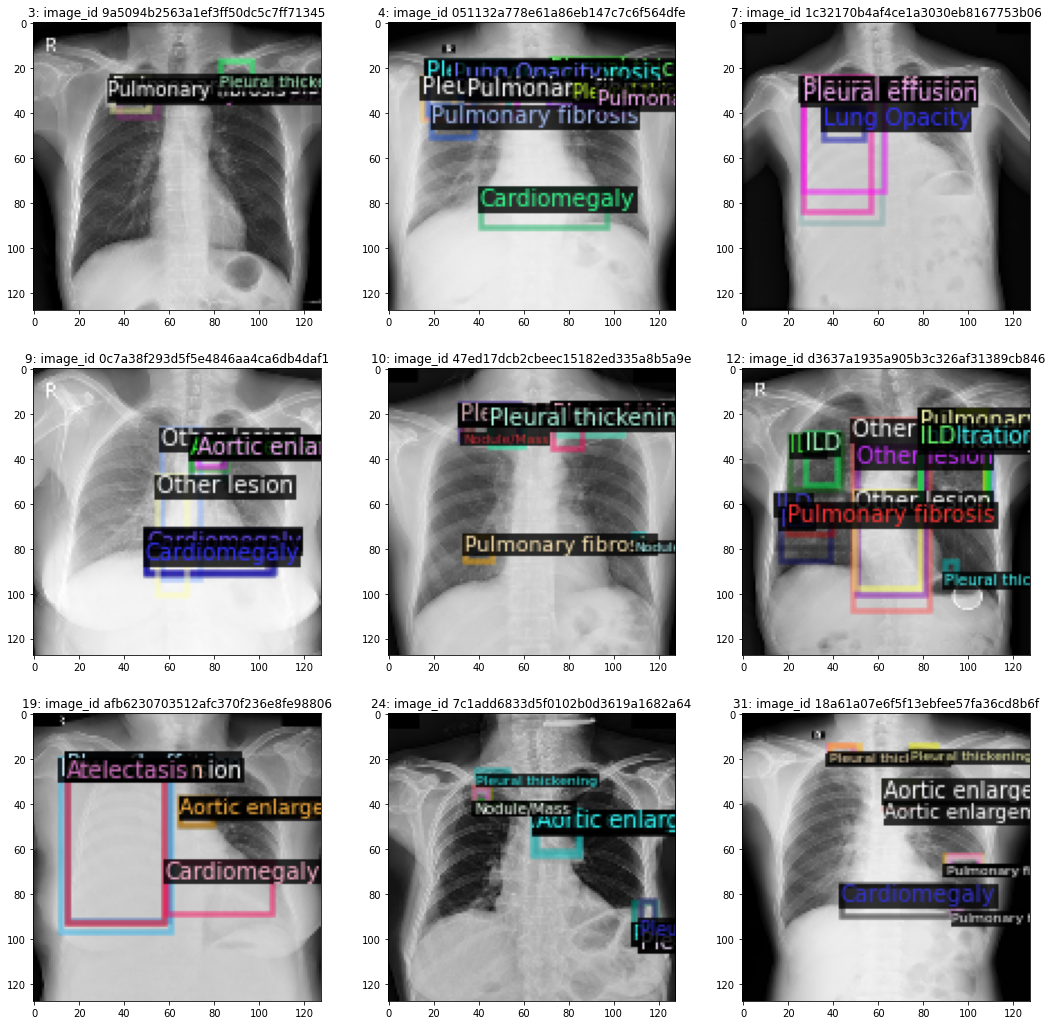

In [50]:
# Visualize data...
anomaly_image_ids = train.query("class_id != 14")["image_id"].unique()
train_meta = pd.read_csv(imgdir/"train_meta.csv")
anomaly_inds = np.argwhere(train_meta["image_id"].isin(anomaly_image_ids).values)[:, 0]

vinbigdata_metadata = MetadataCatalog.get("vinbigdata_train")

cols = 3
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
axes = axes.flatten()

for index, anom_ind in enumerate(anomaly_inds[:cols * rows]):
    ax = axes[index]
    # print(anom_ind)
    d = dataset_dicts[anom_ind]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=vinbigdata_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # cv2_imshow(out.get_image()[:, :, ::-1])
    #cv2.imwrite(str(outdir / f"vinbigdata{index}.jpg"), out.get_image()[:, :, ::-1])
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.set_title(f"{anom_ind}: image_id {anomaly_image_ids[index]}")

<a id="training"></a>
# Training

In [51]:
from detectron2.config.config import CfgNode as CN

def main():
    cfg = get_cfg()
    cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg

    original_output_dir = cfg.OUTPUT_DIR
    cfg.OUTPUT_DIR = str(outdir)
    print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

    config_name = "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
    # config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.DATASETS.TRAIN = ("vinbigdata_train",)
    if split_mode == "all_train":
        cfg.DATASETS.TEST = ()
    else:
        cfg.DATASETS.TEST = ("vinbigdata_valid", "vinbigdata_test")
        cfg.TEST.EVAL_PERIOD = flags.eval_period

    cfg.DATALOADER.NUM_WORKERS = flags.num_workers
    # Let training initialize from model zoo
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
    cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
    cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
    cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
    cfg.SOLVER.MAX_ITER = flags.iter
    cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
    # NOTE: this config means the number of classes,
    # but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = MyTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

In [52]:
from detectron2.engine import default_argument_parser, launch

In [53]:
torch.cuda.device_count()

2

In [54]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
torch.cuda.device_count()

2

In [55]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

main()

Loading config /miniconda/envs/aeolux/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> results/retinanet_split
[04/22 17:29:16 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_fea

It's actually very easy to use multiple gpus for training.

You just need to wrap above training scripts by `main` method and use `launch` method provided by `detectron2`.

Please refer official example [train_net.py](https://github.com/facebookresearch/detectron2/blob/master/tools/train_net.py#L161) for details.

<a id="vis_loss"></a>
# Visualize loss curve & competition metric AP40

As I explained, the calculated metrics are saved in `metrics.json`. We can analyze/plot them to check how the training proceeded.

In [56]:
metrics_df = pd.read_json(outdir / "metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,iteration,loss_box_reg,loss_cls,lr,num_pos_anchors,time,total_loss,validation_loss,vinbigdata_test/bbox/AP,vinbigdata_test/bbox/AP-Aortic enlargement,vinbigdata_test/bbox/AP-Atelectasis,vinbigdata_test/bbox/AP-Calcification,vinbigdata_test/bbox/AP-Cardiomegaly,vinbigdata_test/bbox/AP-Consolidation,vinbigdata_test/bbox/AP-ILD,vinbigdata_test/bbox/AP-Infiltration,vinbigdata_test/bbox/AP-Lung Opacity,vinbigdata_test/bbox/AP-Nodule/Mass,vinbigdata_test/bbox/AP-Other lesion,vinbigdata_test/bbox/AP-Pleural effusion,vinbigdata_test/bbox/AP-Pleural thickening,vinbigdata_test/bbox/AP-Pneumothorax,vinbigdata_test/bbox/AP-Pulmonary fibrosis,vinbigdata_test/bbox/AP50,vinbigdata_test/bbox/AP75,vinbigdata_test/bbox/APl,vinbigdata_test/bbox/APm,vinbigdata_test/bbox/APs,vinbigdata_valid/bbox/AP,vinbigdata_valid/bbox/AP-Aortic enlargement,vinbigdata_valid/bbox/AP-Atelectasis,vinbigdata_valid/bbox/AP-Calcification,vinbigdata_valid/bbox/AP-Cardiomegaly,vinbigdata_valid/bbox/AP-Consolidation,vinbigdata_valid/bbox/AP-ILD,vinbigdata_valid/bbox/AP-Infiltration,vinbigdata_valid/bbox/AP-Lung Opacity,vinbigdata_valid/bbox/AP-Nodule/Mass,vinbigdata_valid/bbox/AP-Other lesion,vinbigdata_valid/bbox/AP-Pleural effusion,vinbigdata_valid/bbox/AP-Pleural thickening,vinbigdata_valid/bbox/AP-Pneumothorax,vinbigdata_valid/bbox/AP-Pulmonary fibrosis,vinbigdata_valid/bbox/AP50,vinbigdata_valid/bbox/AP75,vinbigdata_valid/bbox/APl,vinbigdata_valid/bbox/APm,vinbigdata_valid/bbox/APs
0,0.006910,3813.784100,19,1.243983,2.925054,1.992896e-05,67.375,0.127211,4.239669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,0.005900,3755.641517,19,1.168662,2.882087,1.992896e-05,70.875,0.125272,4.073932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,0.006392,3713.535448,19,1.107919,2.415963,1.992896e-05,87.000,0.123867,3.538851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.006787,3737.554772,39,0.803094,1.162381,3.985418e-05,73.625,0.124359,1.933498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,0.006980,3729.486936,39,0.714247,1.022636,3.985418e-05,75.125,0.124990,1.778696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,0.007080,7.547163,29939,0.320184,0.143335,1.020130e-08,73.000,0.127149,0.460246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1665,0.007304,5.031199,29959,0.308371,0.141836,4.608550e-09,70.250,0.127641,0.444051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1666,0.006519,2.515414,29979,0.336650,0.168468,1.209026e-09,74.875,0.126439,0.533332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1667,0.006203,0.000000,29999,0.302982,0.138526,2.741557e-12,40.000,0.125346,0.455161,0.85715,11.349168,29.356471,8.213315,2.929459,30.555733,13.513734,9.162989,8.900547,9.641597,2.958105,2.953278,15.203318,5.409049,10.510706,9.580056,19.950454,26.478145,26.194813,15.676419,6.552678,11.033972,28.185737,8.416372,1.968334,30.

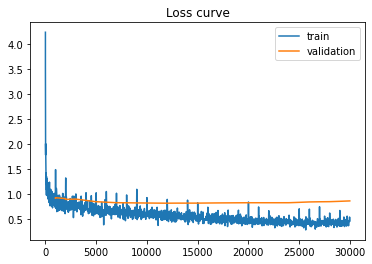

<Figure size 432x288 with 0 Axes>

In [57]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()
plt.savefig(outdir/"loss.png")

In [58]:
mdf.keys()

Index(['data_time', 'eta_seconds', 'iteration', 'loss_box_reg', 'loss_cls',
       'lr', 'num_pos_anchors', 'time', 'total_loss', 'validation_loss',
       'vinbigdata_test/bbox/AP', 'vinbigdata_test/bbox/AP-Aortic enlargement',
       'vinbigdata_test/bbox/AP-Atelectasis',
       'vinbigdata_test/bbox/AP-Calcification',
       'vinbigdata_test/bbox/AP-Cardiomegaly',
       'vinbigdata_test/bbox/AP-Consolidation', 'vinbigdata_test/bbox/AP-ILD',
       'vinbigdata_test/bbox/AP-Infiltration',
       'vinbigdata_test/bbox/AP-Lung Opacity',
       'vinbigdata_test/bbox/AP-Nodule/Mass',
       'vinbigdata_test/bbox/AP-Other lesion',
       'vinbigdata_test/bbox/AP-Pleural effusion',
       'vinbigdata_test/bbox/AP-Pleural thickening',
       'vinbigdata_test/bbox/AP-Pneumothorax',
       'vinbigdata_test/bbox/AP-Pulmonary fibrosis',
       'vinbigdata_test/bbox/AP50', 'vinbigdata_test/bbox/AP75',
       'vinbigdata_test/bbox/APl', 'vinbigdata_test/bbox/APm',
       'vinbigdata_test/bbox/APs

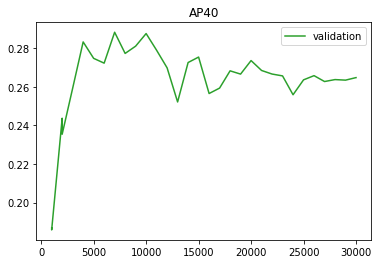

<Figure size 432x288 with 0 Axes>

In [59]:
fig, ax = plt.subplots()
mdf3 = mdf[~mdf["vinbigdata_test/bbox/AP75"].isna()]
ax.plot(mdf3["iteration"], mdf3["vinbigdata_test/bbox/AP75"] / 100., c="C2", label="validation")

ax.legend()
ax.set_title("AP40")
plt.show()
plt.savefig(outdir / "AP40.png")

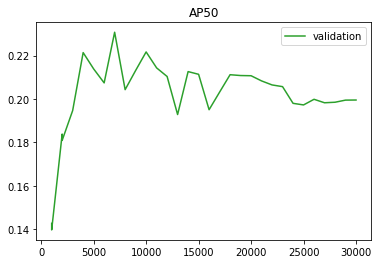

<Figure size 432x288 with 0 Axes>

In [60]:
fig, ax = plt.subplots()
mdf3 = mdf[~mdf["vinbigdata_test/bbox/AP50"].isna()]
ax.plot(mdf3["iteration"], mdf3["vinbigdata_test/bbox/AP50"] / 100., c="C2", label="validation")

ax.legend()
ax.set_title("AP50")
plt.show()
plt.savefig(outdir / "AP50.png")

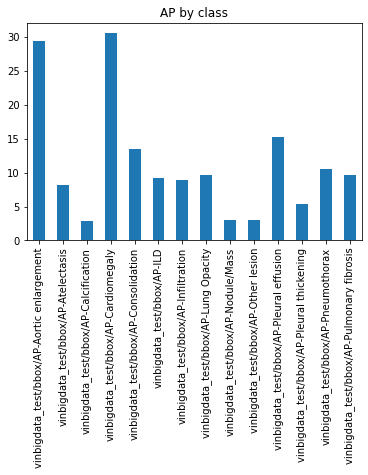

In [61]:
fig, ax = plt.subplots()
mdf_bbox_class = mdf3.iloc[-1][[f"vinbigdata_test/bbox/AP-{col}" for col in thing_classes]]
mdf_bbox_class.plot(kind="bar", ax=ax)
_ = ax.set_title("AP by class")

Our Evaluator calculaes AP by class, and it is easy to check which class is diffucult to train.

In my experiment, **"Calcification" seems to be the most difficult class to predict**.

<a id="vis_aug"></a>
# Visualization of augmentation by Mapper

Let's check the behavior of Mapper method. Since mapper is used inside DataLoader, we can check its behavior by constucting DataLoader and visualize the data processed by the DataLoader.

The defined Trainer class has **class method** `build_train_loader`. We can construct train_loader purely from `cfg`, without instantiating `trainer` since it's class method.

Below code is to visualize the same data 4 times. You can check that augmentation is applied and every time the image looks different.

Note that both `detectron2.data.transforms` & `albumentations` augmentations properly handles bounding box. Thus bounding box is adjusted when the image is scaled, rotated etc!

At first I was using `detectron2.data.transforms` with `MyMapper` class, it provides basic augmentations.<br/>
Then I noticed that we can use many augmentations in `albumentations`, so I implemented `AlbumentationsMapper` to support it.<br/>
How many augmentations can be used in albumentations?<br/>
You can see official github page, all [Pixel-level transforms](https://github.com/albumentations-team/albumentations#pixel-level-transforms) and [Spatial-level transforms](https://github.com/albumentations-team/albumentations#spatial-level-transforms) with "BBoxes" checked can be used. There are really many!!!

In [ ]:
# Visualize data...
# import matplotlib.pyplot as plt
from detectron2.data.samplers import TrainingSampler

n_images = 2
n_aug = 4

fig, axes = plt.subplots(n_images, n_aug, figsize=(16, 8))

# Ref https://github.com/facebookresearch/detectron2/blob/22b70a8078eb09da38d0fefa130d0f537562bebc/tools/visualize_data.py#L79-L88
for i in range(n_aug):
    sampler = TrainingSampler(len(dataset_dicts), shuffle=False)
    train_vis_loader = MyTrainer.build_train_loader(
        cfg, sampler=sampler
    )  # For visualization...
    for batch in train_vis_loader:
        for j, per_image in enumerate(batch):
            ax = axes[j, i]

            img_arr = per_image["image"].cpu().numpy().transpose((1, 2, 0))
            visualizer = Visualizer(
                img_arr[:, :, ::-1], metadata=vinbigdata_metadata, scale=1.0
            )
            target_fields = per_image["instances"].get_fields()
            labels = [
                vinbigdata_metadata.thing_classes[i] for i in target_fields["gt_classes"]
            ]
            out = visualizer.overlay_instances(
                labels=labels,
                boxes=target_fields.get("gt_boxes", None),
                masks=target_fields.get("gt_masks", None),
                keypoints=target_fields.get("gt_keypoints", None),
            )
            # out = visualizer.draw_dataset_dict(per_image)

            img = out.get_image()[:, :, ::-1]
            filepath = str(outdir / f"vinbigdata_{j}_aug{i}.jpg")
            cv2.imwrite(filepath, img)
            print(f"Visualization img {img_arr.shape} saved in {filepath}")
            ax.imshow(img)
            ax.set_title(f"image{j}, {i}-th aug")
        break

That's all! 

I found that the competition data is not so many (15000 for all images, 4000 images after filtering "No finding" images).<br/>
It does not take long time to train (less than a day), so this competition may be a good choice for beginners who want to learn object detection!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated 😁<br>Thanks!</h3>

<a id="next_step"></a>
# Next step

[📸VinBigData detectron2 prediction](https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction) kernel explains how to use trained model for the prediction and submisssion for this competition.

[📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline) kernel explains how to train 2 class classifier model for the prediction and submisssion for this competition.

## Discussions
These discussions are useful to further utilize this training notebook to conduct deeper experiment.

 - [1-step training & prediction](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/219672): The 1-step pipeline which does not use any 2-class classifier approach is proposed.
 - [What anchor size & aspect ratio should be used?](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/220295): Suggests how to predict more smaller sized, high aspect ratio bonding boxes. It affects to the score a lot!!!
 - [Preferable radiologist's id in the test dataset?](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/219221): Investigation of test dataset annotation distribution.
